In [1]:
import os
import argparse
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from keras.models import Sequential, Model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import Bidirectional
from keras.layers import Input, Reshape, Flatten, merge
from keras import optimizers, regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, History
from keras.layers.normalization import BatchNormalization

Using Theano backend.


In [3]:
name = 'helpdesk'
sub_name = 'att_context' #activity-time
args = {
    'inputdir': '../input/{}/'.format(name),   
    'outputdir': './output_files/{0}_{1}/'.format(name, sub_name)
}

args = argparse.Namespace(**args)

In [4]:
if not os.path.isdir(args.outputdir):
    os.makedirs(args.outputdir)

In [5]:
with open(args.inputdir + 'parameters.pkl', "rb") as f:
    maxlen = pickle.load(f)
    num_features = pickle.load(f)
    chartoindice = pickle.load(f)
    targetchartoindice = pickle.load(f)
    divisor = pickle.load(f)
    divisor2 = pickle.load(f)

In [6]:
with open(args.inputdir + 'preprocessed_data.pkl', "rb") as f:
    X = pickle.load(f)
    y_a = pickle.load(f)
    y_t = pickle.load(f)
    X_test = pickle.load(f)
    y_a_test = pickle.load(f)
    y_t_test = pickle.load(f)

# Customized layer

In [7]:
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers, regularizers, constraints

In [8]:
class AttentionWithContext(Layer):
    """
        Attention operation, with a context/query vector, for temporal data.
        Supports Masking.
        Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
        "Hierarchical Attention Networks for Document Classification"
        by using a context vector to assist the attention
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(AttentionWithContext())
        """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = K.dot(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = K.dot(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

# Model 1

In [9]:
# build the model: 
print('Build model attention for activity and output...')
main_input = Input(shape=(maxlen, num_features), name='main_input')

# one shared layer
l1 = LSTM(100, implementation=2, kernel_initializer="glorot_uniform", dropout=0.2, return_sequences=True)(main_input)
b1 = BatchNormalization()(l1)
att_1 = AttentionWithContext()(b1)

l2 = LSTM(100, implementation=2, kernel_initializer="glorot_uniform", dropout=0.2, return_sequences=True)(main_input)
b2 = BatchNormalization()(l1)
att_2 = AttentionWithContext(W_regularizer=regularizers.l2(0.2))(b2)
# last activation

act_output = Dense(len(targetchartoindice), activation="softmax",
                   kernel_initializer="glorot_uniform", name="act_output")(att_1)
time_output = Dense(1, kernel_initializer="glorot_uniform", name="time_output")(att_2)

model = Model(inputs=[main_input], outputs=[act_output, time_output])

#compilations
opt = optimizers.Nadam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004, clipvalue=3)
model.compile(loss={'act_output':'categorical_crossentropy', 'time_output':'mean_absolute_error'}, 
              optimizer=opt, metrics=['accuracy'])

#callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=83)
model_checkpoint = ModelCheckpoint(args.outputdir + 'model_{epoch:02d}-{val_loss:.2f}.h5', 
                                   monitor='val_loss', verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto')
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, 
                               verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
history = History()

#fit
model.fit(X, {'act_output':y_a, 'time_output':y_t}, validation_split=0.2, verbose=2, 
          callbacks=[early_stopping, model_checkpoint, lr_reducer, history], batch_size=16, epochs=500)

Build model attention for activity and output...
Train on 7344 samples, validate on 1837 samples
Epoch 1/500
8s - loss: 7.3415 - act_output_loss: 1.4760 - time_output_loss: 1.0235 - act_output_acc: 0.3012 - time_output_acc: 0.2823 - val_loss: 2.7516 - val_act_output_loss: 1.5799 - val_time_output_loss: 1.0126 - val_act_output_acc: 0.3065 - val_time_output_acc: 0.2869
Epoch 2/500
9s - loss: 2.4624 - act_output_loss: 1.4169 - time_output_loss: 1.0201 - act_output_acc: 0.3208 - time_output_acc: 0.2823 - val_loss: 2.4500 - val_act_output_loss: 1.4301 - val_time_output_loss: 1.0182 - val_act_output_acc: 0.3065 - val_time_output_acc: 0.2869
Epoch 3/500
8s - loss: 2.4342 - act_output_loss: 1.4149 - time_output_loss: 1.0186 - act_output_acc: 0.3207 - time_output_acc: 0.2823 - val_loss: 2.4470 - val_act_output_loss: 1.4285 - val_time_output_loss: 1.0181 - val_act_output_acc: 0.3065 - val_time_output_acc: 0.2869
Epoch 4/500
8s - loss: 2.4316 - act_output_loss: 1.4132 - time_output_loss: 1.0179 -

# Plot 

In [10]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 15, 14)        0                                            
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 15, 100)       46000       main_input[0][0]                 
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 15, 100)       400         lstm_1[0][0]                     
____________________________________________________________________________________________________
batch_normalization_2 (BatchNorm (None, 15, 100)       400         lstm_1[0][0]                     
___________________________________________________________________________________________

In [11]:
history.history.keys()

dict_keys(['time_output_loss', 'loss', 'val_act_output_acc', 'act_output_acc', 'val_time_output_loss', 'act_output_loss', 'lr', 'val_loss', 'val_act_output_loss', 'time_output_acc', 'val_time_output_acc'])

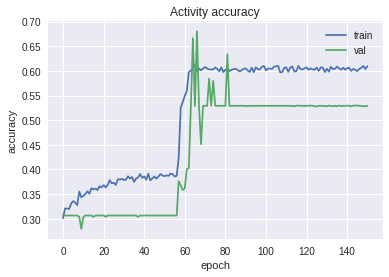

In [12]:
# summarize history for activity accuracy
plt.plot(history.history['act_output_acc'])
plt.plot(history.history['val_act_output_acc'])
plt.title('Activity accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

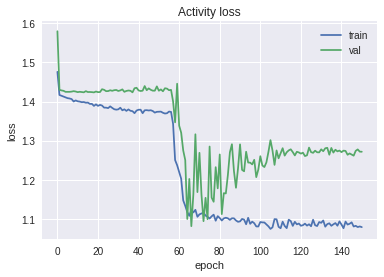

In [13]:
# summarize history for activity loss
plt.plot(history.history['act_output_loss'])
plt.plot(history.history['val_act_output_loss'])
plt.title('Activity loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

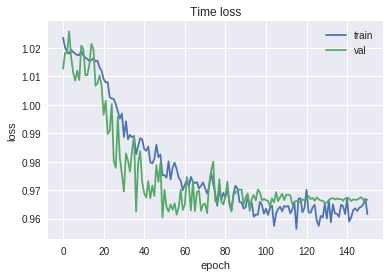

In [14]:
# summarize history for time loss
plt.plot(history.history['time_output_loss'])
plt.plot(history.history['val_time_output_loss'])
plt.title('Time loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

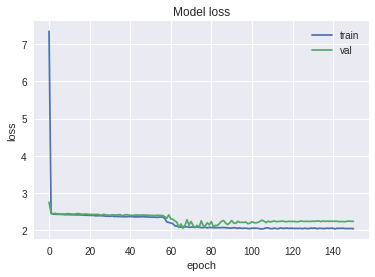

In [15]:
# summarize history for model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()